### Time series forecasting in TensorFlow (BitPredict 💰📈)**
The goal of this notebook is to build a series of models in an attempt to predict the price of Bitcoin.

#### **What is a time series problem?**
Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems one might investigate can usually be broken down into two categories.

| Problem Type | Examples | Output
|--|--|--|
| Classification |  Anomaly detection, time series identification (where did this time series come from?) | Discrete (a label)
| Forecasting | Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements | Continuous (a number)

In both cases above, a supervised learning approach is often used. Meaning, there are some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, the data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what's meant to be predicted).

In [1]:
# Check for GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


### **Get data**
Get the prices of Bitcoin from 01 October 2013 to 11 June 2024.

Why these dates?

Because 01 October 2013 is when the data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording the price of Bitcoin and 11 June 2024 is the stop date i decided to use.

To get the Bitcoin historical data, I connected to coindesk API and extracted the data indicating the start and end date.

In [2]:
import requests
import pandas as pd

# Define the URL for the historical data API
url = "https://api.coindesk.com/v1/bpi/historical/ohlc.json"

# Define the parameters for the API request (start date, end date, and currency)
params = {
    'start': '2013-10-01',
    'end': '2024-06-11',
    'currency': 'USD'
}

# Send a GET request to the API
response = requests.get(url, params=params)

# Convert the JSON response to a Python dictionary
data = response.json()

# Extract OHLC data from the response dictionary
ohlc_data = data['bpi']

# Convert OHLC data to a list of dictionaries with 'BTC' as currency
ohlc_list = [{'Date': date, 'Currency': 'BTC', **values} for date, values in ohlc_data.items()]

# Convert the list of dictionaries to a pandas DataFrame
data = pd.DataFrame(ohlc_list)

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Rename the columns
data.rename(columns={'close': 'Closing Price (USD)', 'open': '24h Open (USD)', 'high': '24h High (USD)', 'low': '24h Low (USD)'}, inplace=True)

# Define the file path for the CSV file
file_path = "bitcoin_price_data.csv"

# Convert the DataFrame to a CSV file
data.to_csv(file_path, index=False)

print(f"CSV file saved successfully at: {file_path}")


CSV file saved successfully at: bitcoin_price_data.csv


### **Importing time series data**

In [3]:
# Import data with pandas
df = pd.read_csv("bitcoin_price_data.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.6550,124.3047,124.7517,122.5635
2013-10-02,BTC,125.4550,123.6550,125.7585,123.6338
2013-10-03,BTC,108.5848,125.4550,125.6657,83.3283
2013-10-04,BTC,118.6747,108.5848,118.6750,107.0582
2013-10-05,BTC,121.3387,118.6747,121.9363,118.0057


In [4]:
# Check the last 5 rows
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2024-06-07,BTC,69458.6146,70824.5955,71909.6980,68678.3234
2024-06-08,BTC,69447.7584,69471.3742,69715.6000,69305.1931
2024-06-09,BTC,69683.6751,69443.3619,69956.6501,69255.7720
2024-06-10,BTC,69441.3017,69671.5386,70106.0993,69210.6215
2024-06-11,BTC,67379.9128,69542.6865,69584.2985,66187.1230


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3903 entries, 2013-10-01 to 2024-06-11
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             3903 non-null   object 
 1   Closing Price (USD)  3903 non-null   float64
 2   24h Open (USD)       3903 non-null   float64
 3   24h High (USD)       3903 non-null   float64
 4   24h Low (USD)        3903 non-null   float64
dtypes: float64(4), object(1)
memory usage: 183.0+ KB


In [6]:
len(df)

3903

After collecting the historical price of Bitcoin for the past ~11 years, there's only 3903 total samples.

These are some of the issues associated with time series data. Often, the number of samples isn't as large as other kinds of data.

The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually measured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand being higher when it's hot for air conditioning than when it's cold during harmattan). For more on different time series patterns, see [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In this case, I've got the daily prices of Bitcoin, a max of 365 samples per year.

To simplify the data, remove some of the columns from the data so what is left is the date index and the closing price.

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.6550
2013-10-02,125.4550
2013-10-03,108.5848
2013-10-04,118.6747
2013-10-05,121.3387


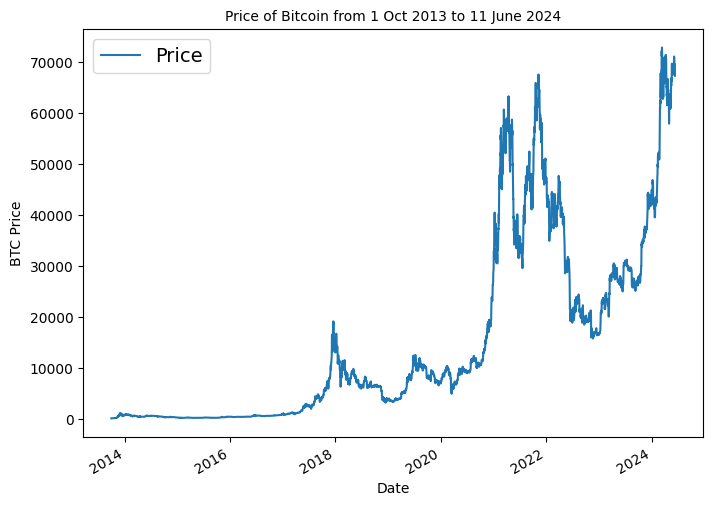

In [8]:
# Plot the data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(8, 6))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 11 June 2024", fontsize=10)
plt.legend(fontsize=14);

### **Format Data Part 1: Creating train and test sets for time series data**
In time series problems, you'll either have **univariate** or **multivariate** data.

- **Univariate** time series data deals with one variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
- **Multivariate** time series data deals with more than one variable, for example, predicting electricity demand using the day of week, time of year and number of houses in an area.

In [9]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.655 , 125.455 , 108.5848, 118.6747, 121.3387, 120.6553,
        121.795 , 123.033 , 124.049 , 125.9612]))

In [10]:
# Create train and test splits the right way for the time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(3122, 781, 3122, 781)

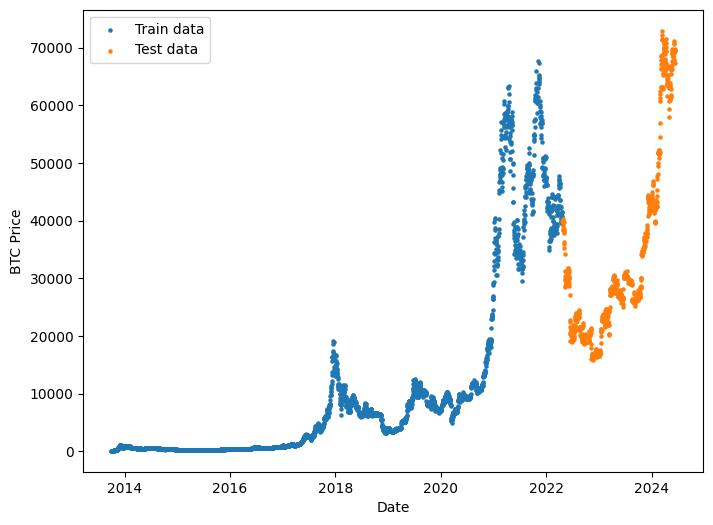

In [11]:
# Plot correctly made splits
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=10)
plt.show();

I'm going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an artificial future, It can be used to gauge how the model might perform on actual future data.

Working with time series data can be tricky compared to other kinds of data. And there are a few pitfalls to watch out for, such as how much data to use for a test set. The article [3 facts about time series forecasting that surprise experienced machine learning practitioners](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) talks about different things to watch out for when working with time series data.

### **Create a plotting function**
Create a `matplotlib` plotting function for reuse later.

In [12]:
# create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps: array of timesteps
  values: array of values across time
  format: style of plot, default "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (setting a value will index from end of timesteps & values)
  label: label to show on plot of values
  """
  # Plot the values
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=12)
  plt.grid(True)

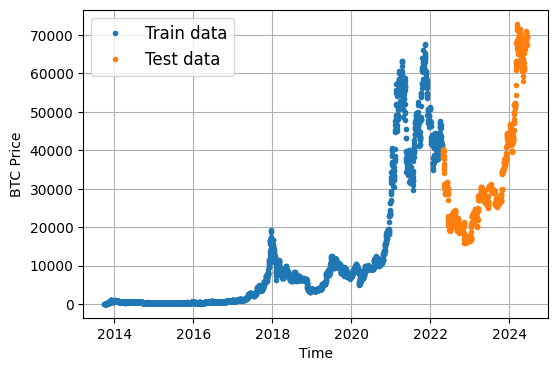

In [13]:
# Try the plotting function
plt.figure(figsize=(6, 4))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

### **Modelling Experiments**
Almost any kind of model can be built for this problem as long as the data inputs and outputs are formatted correctly.

However, just because any kind of model can be built, doesn't mean it'll perform well/should be used in a production setting.

This will be seen as we build and evaluate models throughout.

Before discussing what modelling experiments will be run, there are two terms to be familiar with, **horizon** and **window**.

- **horizon** = number of timesteps to predict into future
- **window** = number of timesteps from past used to predict **horizon**

For example, if the goal is to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

| Model Number	| Model Type	| Horizon size	| Window size	| Extra data|
|--|--|--|--|--|
|0	| Naïve model(baseline) |	NA	| NA	| NA |
|1	| Dense model	| 1	| 7	|NA |
|2	|Same as 1|	1|	30|	NA|
|3	|Conv1D	|7	| 30	| NA |
|4	|LSTM	|1	|7	|NA |
|5	|Same as 1 (but with multivariate data)	|1	|7	|Block reward size |
|6	|N-BEATs Algorithm	|1	|7	|NA |
|7	|Ensemble (multiple models optimized on different loss functions)	|1	|7	|NA |
|8	|Future prediction model (model to predict future values)	|1	|7	|NA |
|9	|Same as 1 (but with turkey 🦃 data introduced)	|1	|7	|NA |

### **Model 0: Naive forecast (baseline)**
One of the most common baseline models for time series forecasting, the naive model (also called the [naive forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naive model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

In an open system (like a stock market or crypto market), beating the naive forecast with any kind of model is quite hard.

**🔑 Note**: For the sake of this project, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [14]:
# create a naive forecast
naive_forecast =y_test[:-1] # Naive forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # view the first 10 and last 10

(array([39899.3414, 39620.7263, 40331.277 , 38301.7037, 39077.3846,
        39678.5854, 38557.1893, 38380.673 , 38210.6675, 38590.2299]),
 array([67789.7859, 67891.8579, 69109.3176, 70565.2068, 71158.5455,
        70830.2702, 69458.6146, 69447.7584, 69683.6751, 69441.3017]))

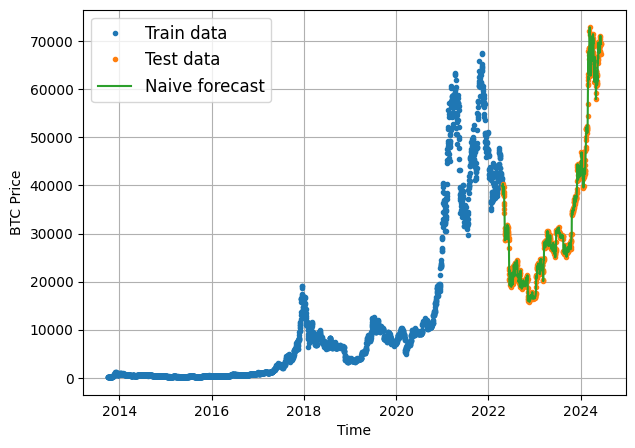

In [15]:
# plot naive forecast
plt.figure(figsize=(7, 5))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast")

The naive forecast looks like it's following the data well.

Zoom in to take a better look.

To zoom in, create an offset value and pass it to the `start` parameter of the `plot_time_series()` function.

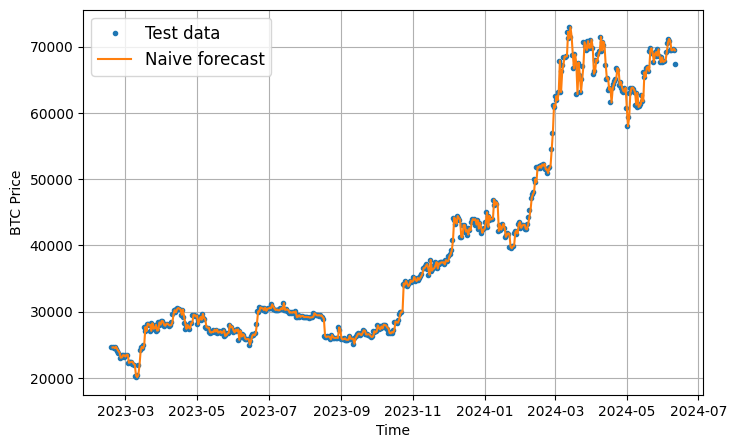

In [16]:
plt.figure(figsize=(8, 5))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast")

After zooming in, the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Evaluate it.

### **Evaluating a time series model**
Time series forecasting often involves predicting a number (in this case, the price of Bitcoin).

Regression evaluation metrics can be used to evaluate the time series forecasts.

The main thing to be evaluated is: **how do the model's predictions (y_pred) compare against the actual values (y_true or ground truth values)**?

For all of the following metrics, **lower is better** (for example an MAE of 0 is better than an MAE 100).

#### **Scale-dependent errors**
These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD versus Bitcoin forecast values in USD.

|Metric	|Details	|Code |
|--|--|--|
|MAE (mean absolute error)	|Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median.	|[tf.keras.metrics.mean_absolute_error()](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError)|
|RMSE (root mean square error)	|Forecasts which minimise the RMSE lead to forecasts of the mean.	|[tf.sqrt(tf.keras.metrics.mean_square_error())](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)|

#### **Percentage errors**
Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

|Metric	|Details	|Code |
|--|--|--|
|MAPE (mean absolute percentage error)	|Most commonly used percentage error. May explode (not work) if `y=0`.	| [tf.keras.metrics.mean_absolute_percentage_error()](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) |
|sMAPE (symmetric mean absolute percentage error)	| Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions.	| Custom implementation |

#### **Scaled errors**
Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

|Metric	|Details	|Code |
|--|--|--|
|MASE (mean absolute scaled error).	|MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE.	| See sktime's [mase_loss()](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

There are so many metrics and deciding on which one to use is going to depend on the problem. However, since its ease of interpretation (you can explain it in a sentence to your grandma), MAE is often a very good place to start.

TensorFlow doesn't have a ready made version of MASE (mean absolute scaled error).

Take inspiration from [sktime's](https://github.com/alan-turing-institute/sktime) (Scikit-Learn for time series) [MeanAbsoluteScaledError](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.MeanAbsoluteScaledError.html#sktime.performance_metrics.forecasting.MeanAbsoluteScaledError) class which calculates the MASE.



In [17]:
# Let's get TensorFlow!
import tensorflow as tf

In [18]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # the seasonality is 1 day(hence the shifting of 1 day)

  return mae / mae_naive_no_season

This version of MASE above doesn't take in the training values like sktime's `mae_loss()`. In this case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if a function has been created correctly, the naive model should achieve an MASE of 1 (or very close to 1). Any model worse than the naive forecast will achieve an MASE of >1 and any model better than the naive forecast will achieve an MASE of <1.

Put each of the different evaluation metrics together into a function.

In [19]:
def evaluate_preds(y_true, y_pred):
  # make sure float32 dtype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # calculate various metrics
  mae =tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts an emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [20]:
# test the above function on the naive forecast
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 622.8182,
 'mse': 996736.8,
 'rmse': 998.36707,
 'mape': 1.8578315,
 'mase': 0.9992911}

Taking a look at the naive forecast's MAE, it seems on average each forecast is ~$622 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [21]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

33054.03851510883

Okay, looking at these two values is starting to give an idea of how the model is performing:

- The average price of Bitcoin in the test dataset is: $32440 (note: average may not be the best measure here, since the highest price is over 2x this value and the lowest price is over 4x lower)

- Each prediction in naive forecast is on average off by: $622

Train a different model whose results are closer to the mark.

### **Other kinds of time series forecasting models which can be used for baselines and actual forecasts**
Now that a naïve forecast baseline model has been built, it's time to start building other models to try and beat it.

|Model/Library Name	| Resource |
|--|--|
|Moving average	|https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/|
|ARIMA (Autoregression Integrated Moving Average)	|https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
sktime (Scikit-Learn for time series)	|https://github.com/alan-turing-institute/sktime|
|TensorFlow Decision Forests (random forest, gradient boosting trees)	| https://www.tensorflow.org/decision_forests|
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)	| https://github.com/facebookresearch/Kats|
|LinkedIn Greykite (flexible, intuitive and fast forecasts)	| https://github.com/linkedin/greykite|


### **Format Data Part 2: Windowing dataset**
The next step is to window the time series.

Why is window needed?

Windowing is a method to turn a time series dataset into **supervised learning problem**.

In other words, use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

`Window for one week (univariate time series)`

```
[0, 1, 2, 3, 4, 5, 6] -> [7]

[1, 2, 3, 4, 5, 6, 7] -> [8]

[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

`Window for one week with the target of predicting the next day (Bitcoin prices)`

```
[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Build some functions which takes in a univariate time series and turns it into windows and horizons of specified sizes.

Start with a default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [22]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [23]:
# create a function that takes in an array and turns it into a labeled windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset
  e.g if horizon = 1(default)
  input: [1, 2, 3, 4, 5, 6] -> output: ([1, 2, 3, 4, 5,], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [24]:
# Test out windowed labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) +1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Time to find a way to make windows for an entire time series.

This could be done with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example:

    ```
    [[0, 1, 2, 3, 4, 5, 6, 7],

     [1, 2, 3, 4, 5, 6, 7, 8],

     [2, 3, 4, 5, 6, 7, 8, 9]]
     ```

3. Uses the 2D array of multiple window steps to index on a target series(e.g the historical price of bitcoin)
4. Uses the `get_labelled_windows()` function created above to turn the window steps into windows with a specified horizon

**📖 Resource**: The function created below has been adapted from Syafiq Kamarul Azman's article [Fast and Robust Sliding Window Vectorization with NumPy](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [25]:
import numpy as np

In [26]:
# Create function to view Numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [27]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3896, 3896)

In [28]:
# view the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.655  125.455  108.5848 118.6747 121.3387 120.6553 121.795 ] -> Label: [123.033]
Window: [125.455  108.5848 118.6747 121.3387 120.6553 121.795  123.033 ] -> Label: [124.049]
Window: [108.5848 118.6747 121.3387 120.6553 121.795  123.033  124.049 ] -> Label: [125.9612]


In [29]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [67891.8579 69109.3176 70565.2068 71158.5455 70830.2702 69458.6146
 69447.7584] -> Label: [69683.6751]
Window: [69109.3176 70565.2068 71158.5455 70830.2702 69458.6146 69447.7584
 69683.6751] -> Label: [69441.3017]
Window: [70565.2068 71158.5455 70830.2702 69458.6146 69447.7584 69683.6751
 69441.3017] -> Label: [67379.9128]


### **Turning windows into training and test sets**
Time to turn the windows into training and test splits.

I could've windowed the existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [30]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1 - test_split)) # this will default to 80% train / 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels =labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [31]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3116, 780, 3116, 780)

In [32]:
# View the first 5 samples of train_windows and train_labels
train_windows[:5], train_labels[:5]

(array([[123.655 , 125.455 , 108.5848, 118.6747, 121.3387, 120.6553,
         121.795 ],
        [125.455 , 108.5848, 118.6747, 121.3387, 120.6553, 121.795 ,
         123.033 ],
        [108.5848, 118.6747, 121.3387, 120.6553, 121.795 , 123.033 ,
         124.049 ],
        [118.6747, 121.3387, 120.6553, 121.795 , 123.033 , 124.049 ,
         125.9612],
        [121.3387, 120.6553, 121.795 , 123.033 , 124.049 , 125.9612,
         125.2797]]),
 array([[123.033 ],
        [124.049 ],
        [125.9612],
        [125.2797],
        [125.9275]]))

In [33]:
# Check to see if train labels are the same (before and after window split, accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

### **Make a modelling checkpoint**
Because the model's performance will fluctuate from experiment to experiment, make sure apples is being compared to apples.

What this means is in order for a fair comparison, compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of the other models: compare the best against the best.

Implement a [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor the model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating the model, the best performing configuration can be restored from file.



In [34]:
import os

# Create  function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose = 0, # only output a limited amount of text
                                            save_best_only = True) # save only the best model to file

### **Model 1: Dense model (window = 7, horizon = 1)**

Often, preparing data for a model is one of the largest parts of any machine learning project.

And once there is a good model in place, there are more improvements from manipulating the data (e.g. collecting more, improving the quality) than manipulating the model.



In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# set random seed for reproducible results as possible
tf.random.set_seed(42)

# construct the model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense")

# compile the model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# fit the model
model_1.fit(x=train_windows, # train windows of 7 timesteps of bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict the next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create Modelcheckpint callback to save best model)


Epoch 1/100
25/25 [==============================] - 4s 100ms/step - loss: 2134.3838 - mae: 2134.3838 - val_loss: 2752.7119 - val_mae: 2752.7119
Epoch 2/100
25/25 [==============================] - 2s 69ms/step - loss: 549.9762 - mae: 549.9762 - val_loss: 933.9713 - val_mae: 933.9713
Epoch 3/100
25/25 [==============================] - 2s 103ms/step - loss: 444.1591 - mae: 444.1591 - val_loss: 869.8536 - val_mae: 869.8536
Epoch 4/100
25/25 [==============================] - 0s 17ms/step - loss: 436.8373 - mae: 436.8373 - val_loss: 965.2795 - val_mae: 965.2795
Epoch 5/100
25/25 [==============================] - 3s 131ms/step - loss: 423.9028 - mae: 423.9028 - val_loss: 851.4137 - val_mae: 851.4137
Epoch 6/100
25/25 [==============================] - 2s 92ms/step - loss: 407.0841 - mae: 407.0841 - val_loss: 777.2587 - val_mae: 777.2587
Epoch 7/100
25/25 [==============================] - 0s 13ms/step - loss: 392.5264 - mae: 392.5264 - val_loss: 785.1168 - val_mae: 785.1168
Epoch 8/100
2

`Model_1` above has:

1. A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
2. An output layer with linear activation (or no activation)
3. Adam optimizer and MAE loss function
4. Batch size of 128
5. 100 epochs

In [36]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

25/25 [==============================] - 0s 1ms/step - loss: 634.6393 - mae: 634.6393


[634.6392822265625, 634.6392822265625]

The model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if the version of `model_1` which was saved to file using the `ModelCheckpoint` callback is loaded, there should be an improvement in results.

In [37]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

25/25 [==============================] - 0s 2ms/step - loss: 618.9135 - mae: 618.9135


[618.9134521484375, 618.9134521484375]

Due to the fluctuating performance of the model during training, loading back the best performing model see's an improvement in MAE.

### **Making forecasts with a model (on the test dataset)**
Since more modelling experiments are going to be carried out, write a function which:

1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [38]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  -----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [39]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

25/25 [==============================] - 0s 2ms/step


(780,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([39831.45 , 39616.633, 40203.582, 38468.105, 38884.637, 39623.84 ,
        38652.39 , 38327.984, 38168.945, 38531.605], dtype=float32)>)

**🔑 Note**: With these outputs, the model isn't forecasting yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

Use the `evaluate_preds()`that was created before to compare them to the ground truth.

In [40]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 618.91345,
 'mse': 990477.4,
 'rmse': 995.2273,
 'mape': 1.8545363,
 'mase': 0.9930261}

Compare with the naive forecast

In [41]:
naive_results

{'mae': 622.8182,
 'mse': 996736.8,
 'rmse': 998.36707,
 'mape': 1.8578315,
 'mase': 0.9992911}

There isn't much difference between the naive result and model_1_results.

Use the `plot_time_series()` function to plot `model_1_preds` against the test data.


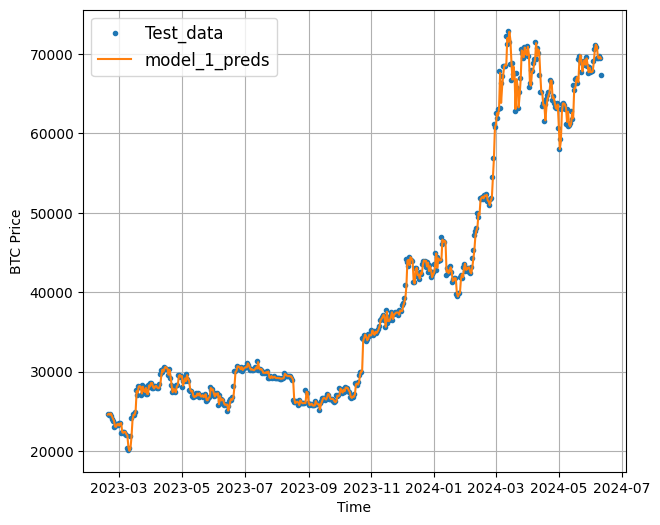

In [42]:
# Plot model 1 predictions
offset = 300
plt.figure(figsize=(7, 6))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

The predictions above are on the test dataset. So they're not actual forecasts.

### **Model 2: Dense (window = 30, horizon = 1)**
Keep the previous model architecture but use a window size of 30.

In other words, use the previous 30 days of Bitcoin prices to try and predict the next day price.

**🔑 Note**: The window size (how many timesteps to use to fuel a forecast) and the horizon (how many timesteps to predict into the future) are **hyperparameters**. This means one can tune them to try and find values which might result in better performance.

Start the second modelling experiment by preparing datasets using the functions created earlier.

In [43]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [44]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3873, 3873)

In [45]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3098, 775, 3098, 775)

Construct `model_2`, a model with the same architecture as `model_1` as well as the same training routine.

In [46]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

25/25 [==============================] - 0s 1ms/step - loss: 707.4097


707.4097290039062

In [48]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

25/25 [==============================] - 0s 2ms/step - loss: 653.6395


653.6395263671875

Loading back in the best performing model see's a performance boost.

Make some predictions with `model_2` and then evaluate.



In [49]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

25/25 [==============================] - 0s 1ms/step


In [50]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 653.63965,
 'mse': 1066077.1,
 'rmse': 1032.5101,
 'mape': 1.9822246,
 'mase': 1.0533769}

`Model_2` performs worse than the naïve model as well as `model_1!`

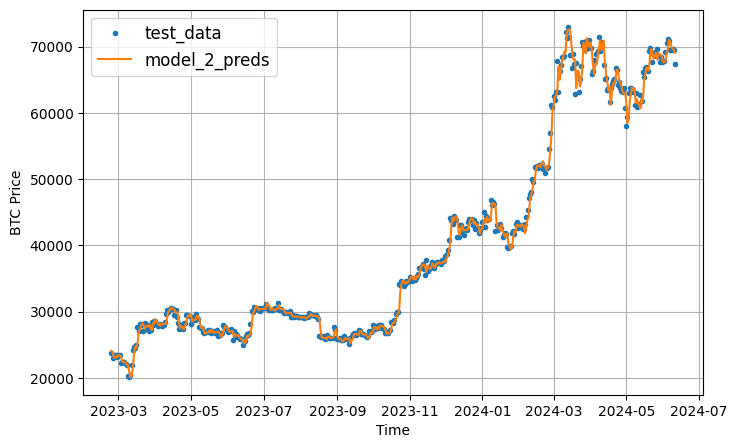

In [51]:
offset = 300
plt.figure(figsize=(8, 5))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="test_data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_2_preds,
                 start=offset, format="-",
                 label="model_2_preds")

### **Model 3: Dense (window = 30, horizon = 7)**
Try and predict 7 days ahead given the previous 30 days.

First, update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.

In [52]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3867, 3867)

Split the full dataset windows into training and test sets.

In [53]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [54]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

25/25 [==============================] - 0s 1ms/step - loss: 963.8729


963.8729248046875

In [55]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

25/25 [==============================] - 0s 2ms/step - loss: 691.7153


691.7152709960938

The error is slightly higher because we're predicting 7 steps at a time.

The further you try and predict, the larger the error will be (think of trying to predict the weather 7 days in advance).

Make predictions with the model using the `make_preds()` function and evaluate them using the `evaluate_preds()` function.

In [56]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

25/25 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[39075.72 , 39401.965, 39364.773, 39667.367, 39526.598, 40173.37 ,
        39678.723],
       [38921.25 , 38539.555, 38467.36 , 38827.15 , 38625.906, 39380.754,
        39150.4  ],
       [37947.56 , 38228.08 , 38347.63 , 38180.223, 38664.977, 38631.055,
        38728.973],
       [38046.145, 38596.168, 38122.363, 38511.258, 38358.008, 38618.22 ,
        38562.03 ],
       [37879.754, 38190.746, 38573.793, 38108.29 , 38395.504, 38792.676,
        38422.664]], dtype=float32)>

In [57]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 998.31476 ,  463.95258 ,  262.9894  ,  197.89621 ,  550.0893  ,
        1920.3444  , 2689.1233  , 1187.3733  , 1002.0435  , 1110.279   ,
        3121.134   , 1251.1189  , 2158.4985  ,  297.9177  , 1186.8201  ,
         332.69223 , 1535.9609  ,  506.49582 ,  667.84344 , 1588.3331  ,
         600.84265 ,  692.79913 ,  340.60184 ,  965.1381  ,  926.38196 ,
         218.03181 ,  475.6225  ,  458.73828 ,  630.8343  ,  224.6381  ,
         428.56668 , 2133.1313  ,  898.19196 , 2257.286   ,  532.5717  ,
         548.97235 ,  179.87277 ,  400.851   , 2037.0299  ,  546.0739  ,
         531.5218  ,  505.93863 , 1217.2296  ,  611.2397  , 1682.2229  ,
        4598.646   , 2433.5586  ,  749.18304 , 1556.8878  ,  481.12082 ,
        1082.0491  ,  848.5904  ,  287.08286 ,  149.25558 , 1306.9095  ,
         612.49524 ,  312.27985 ,  243.79826 ,  877.356   ,  307.34793 ,
         786.24414 ,  235.59402 , 1621.7567  ,  253.91853 ,  207.84543 ,
         194.67131 ,  204.48967 ,  738.2285 

### **Make the evaluation function work for larger horizons**
The outputs for `model_3_results` are multi-dimensional.

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, adjust the `evaluate_preds()` function to work with multiple shapes of data.

In [58]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [59]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_3_preds)
model_3_results

{'mae': 691.71515,
 'mse': 1131972.8,
 'rmse': 734.93243,
 'mape': 2.100981,
 'mase': 1.1147379}

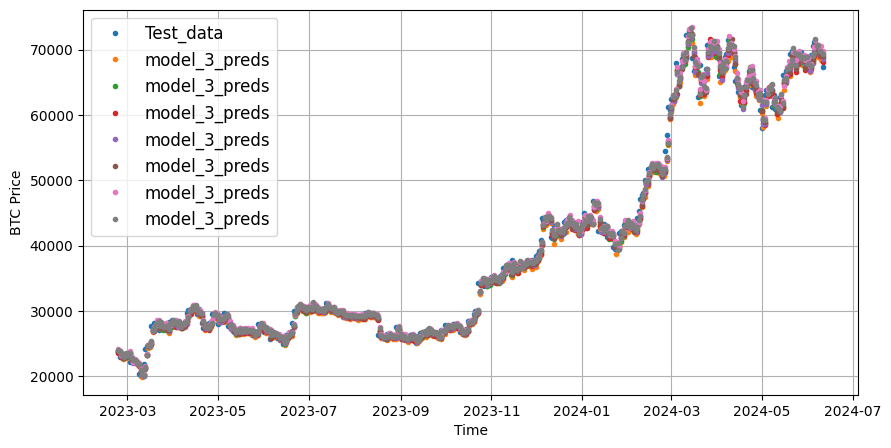

In [60]:
offset = 300
plt.figure(figsize=(10, 5))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")

# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

The plot above is not so clear. It can be fixed by aggregating the model's predictions.

**🔑 Note**: Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

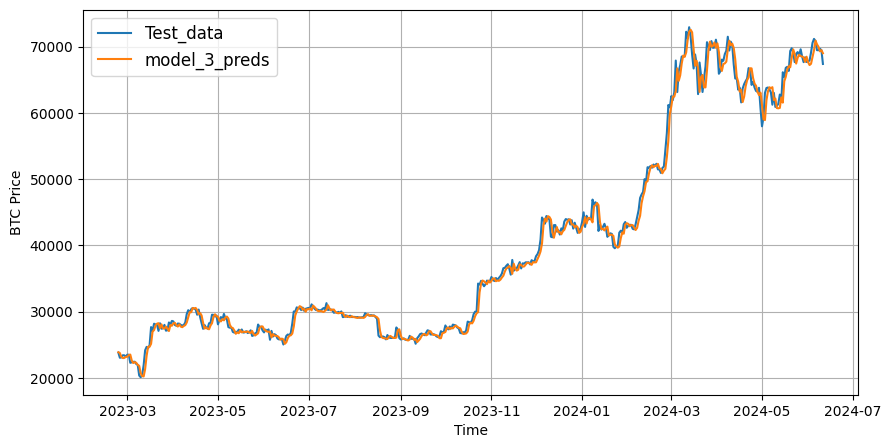

In [61]:
offset = 300
plt.figure(figsize=(10, 5))

# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look further ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 format="-",
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

### **Which of the models is performing best so far?**
3 models have been trained which use the same architecture but use different data inputs.

Compare them with the naïve model to see which model is performing the best so far.

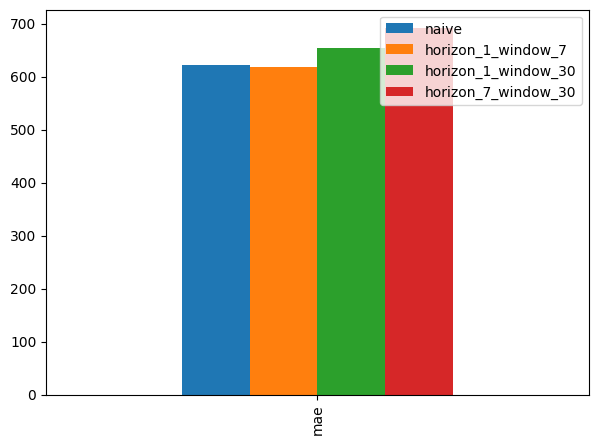

In [62]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(7, 5), kind="bar");

Model_1 with a horizon of 1 and window of 7 is performing better than the other models including the naive model but the naive model looks to be performing closest.

Use `HORIZON=1` and `WINDOW_SIZE=7` for the next series of modelling experiments (Use the previous week of Bitcoin prices to try and predict the next day).

**🔑 Note**: You might be wondering, why are the naïve results really good and almost similar to model_1? One of the reasons could be due to the presence of **autocorrelation** in the data. If a time series has **autocorrelation** it means the value at `t+1` (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.

**📖 Resource**: For more on how autocorrelation influences a model's predictions, see the article [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik

### **Model 4: Conv1D**
This time, a Conv1D model is going to be used because Conv1D models can be used for seq2seq (sequence to sequence) problems.

In this case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

Before the Conv1D model is built, recreate the datasets.

In [63]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [64]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3896, 3896)

In [65]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3116, 780, 3116, 780)

Data windowed!

Now, since a Conv1D model is going to be used [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), make sure the input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: (`batch_size, timesteps, input_dim`).

In this case, the `batch_size` (by default this is 32 but can be changed) is handled for us but the other values will be:

- `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, the `features` are the previous `WINDOW_SIZE` values of Bitcoin
- `input_dim = HORIZON` - the model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, the data has the `timesteps` dimension ready but it has to be adjusted so it can have the `input_dim` dimension.

In [66]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, adjust the shape of all of the `train_windows` or use a [tf.keras.layers.Lamdba](https://keras.io/api/layers/core_layers/lambda/) (called a Lambda layer) to do this in the model.

The Lambda layer wraps a function into a layer which can be used with a model.

In [67]:
# Before we pass the data to the Conv1D layer, reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.655 ]
 [125.455 ]
 [108.5848]
 [118.6747]
 [121.3387]
 [120.6553]
 [121.795 ]]


Now that the Lambda layer has been created, let's build, compile, fit and evaluate a Conv1D model on the data.

**🔑 Note**: If you run the model below without the Lambda layer, you'll get an input shape error (one of the most common errors when building neural networks).

In [68]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    # Create Lambda layer to reshape inputs, without this layer, the model will error
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size/Conv1D 3D input requirements
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile the model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [69]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The Lambda layer appears the same as any other regular layer.

Time to evaluate the Conv1D model.

In [70]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

25/25 [==============================] - 0s 2ms/step - loss: 624.8770


624.8770141601562

In [71]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

25/25 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([39726.652, 39540.902, 40099.582, 38613.36 , 38870.97 , 39386.926,
       38750.56 , 38356.605, 38122.082, 38435.293], dtype=float32)>

In [72]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 624.877,
 'mse': 1003773.8,
 'rmse': 1001.88513,
 'mape': 1.879967,
 'mase': 1.0025945}

### **Model 5: RNN (LSTM)**
Recurrent neural network can also be used to model sequential time series data.

**📖 Resource**: For more on the different types of recurrent neural networks to use for sequence problems, see the [Recurrent Neural Networks section of notebook 08](https://dev.mrdbourke.com/tensorflow-deep-learning/08_introduction_to_nlp_in_tensorflow/#recurrent-neural-networks-rnns).

Reuse the same data that was used for the Conv1D model, except this time an [LSTM-cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) powered RNN will be created to model the Bitcoin data.

Once again, one of the most important steps for the LSTM model will be getting the data into the right shape.

The [tf.keras.layers.LSTM()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.

The `batch` dimension gets taken care of but the data currently only has the `feature` dimension (`WINDOW_SIZE`).

To fix this, just like the `Conv1D` model, use a `tf.keras.layers.Lambda()` layer to adjust the shape of the input tensors to the LSTM layer.

In [73]:
tf.random.set_seed(42)

# Build an LSTM model with Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile the model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [74]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

25/25 [==============================] - 0s 3ms/step - loss: 636.5385


636.5385131835938

In [75]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

25/25 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([39761.883, 39537.453, 40045.07 , 38729.652, 38829.73 , 39376.586,
       38717.27 , 38495.863, 38087.977, 38394.05 ], dtype=float32)>

In [76]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 636.53864,
 'mse': 1027358.44,
 'rmse': 1013.5869,
 'mape': 1.9174663,
 'mase': 1.0213051}

The LSTM-powered RNN was not able to beat the model_1 or naïve models results.

### **Make a multivariate time series**
All of the models have barely kept up with the naïve and model_1 forecast.

And so far all of them have been trained on a single variable (also called univariate time series): the historical price of Bitcoin.

If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving the models more information may help.

More information is a vague term because we could actually feed almost anything to the model(s) and they would still try to find patterns.

It will be better if we passed the model something related to Bitcoin (again, this is quite vauge, since in an open system like a market, one could argue everything is related).

This will be different for almost every time series project but in this case, try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) adds any predictive power to the model(s).

What is the Bitcoin block reward size?

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 3.125 BTC on April 19 2024.

Encode this information into the time series data and see if it helps a model's performance.

**🔑 Note**: Adding an extra feature to the dataset such as the Bitcoin block reward size will take the data from **univariate** (only the historical price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

In [77]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.6550
2013-10-02,125.4550
2013-10-03,108.5848
2013-10-04,118.6747
2013-10-05,121.3387


Add another feature column called the block reward size.

First, create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).


|Block Reward	| Start Date|
|--|--|
|50	|3 January 2009 (2009-01-03)
|25	|28 November 2012
|12.5	|9 July 2016
|6.25	|11 May 2020
|3.125	|19 April 2024
|1.5625	|TBA (expected 2028)

**🔑 Note**: Since the Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [78]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in the dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020
block_reward_5 = 3.125 # 19 April 2024

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")
block_reward_5_datetime = np.datetime64("2024-04-19")

Get the days (indexes) for different block reward values.

This is important because if multiple variables are going to be used for the time series problem, they have to have the same frequency as the original variable. For example, if the Bitcoin prices are daily, we need the block reward values to be daily as well.

**🔑 Note**: For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [79]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_4_days = (block_reward_5_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days, block_reward_4_days

(1012, 2414, 3853)

Add another feature to the dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [80]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:block_reward_4_days, -1] = block_reward_4
bitcoin_prices_block.iloc[block_reward_4_days:, -1] = block_reward_5
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.6550,12.5
2013-10-02,125.4550,12.5
2013-10-03,108.5848,12.5
2013-10-04,118.6747,12.5
2013-10-05,121.3387,12.5


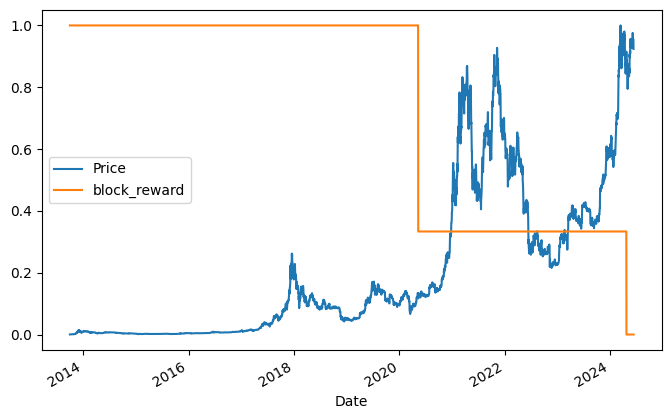

In [81]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(8, 5));

When the block reward is scaled and the Bitcoin price, the price goes up as the block reward goes down, perhaps this information will be helpful to the model's performance.

### **Making a windowed dataset with pandas**
Previously, a custom made functions was used to window the **univariate** time series.

However, since another variable has been added to the dataset, these functions won't work.

The data is in a pandas DataFrame and the [pandas.DataFrame.shift()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method can be leveraged to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.

In [82]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [83]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.6550,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.4550,12.5,123.6550,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.5848,12.5,125.4550,123.6550,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.6747,12.5,108.5848,125.4550,123.6550,NaN,NaN,NaN,NaN
2013-10-05,121.3387,12.5,118.6747,108.5848,125.4550,123.6550,NaN,NaN,NaN
2013-10-06,120.6553,12.5,121.3387,118.6747,108.5848,125.4550,123.6550,NaN,NaN
2013-10-07,121.7950,12.5,120.6553,121.3387,118.6747,108.5848,125.4550,123.6550,NaN
2013-10-08,123.0330,12.5,121.7950,120.6553,121.3387,118.6747,108.5848,125.4550,123.6550
2013-10-09,124.0490,12.5,123.0330,121.7950,120.6553,121.3387,118.6747,108.5848,125.4550


Now that a windowed dataset has been created, separate features (`X`) from labels (`y`).

In the windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

Remove the `NaN` values using pandas [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method, this equivalent to starting the windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [84]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,12.5,121.794998,120.655296,121.338699,118.674698,108.584801,125.455002,123.654999
2013-10-09,12.5,123.032997,121.794998,120.655296,121.338699,118.674698,108.584801,125.455002
2013-10-10,12.5,124.049004,123.032997,121.794998,120.655296,121.338699,118.674698,108.584801
2013-10-11,12.5,125.961197,124.049004,123.032997,121.794998,120.655296,121.338699,118.674698
2013-10-12,12.5,125.279701,125.961197,124.049004,123.032997,121.794998,120.655296,121.338699


In [85]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961197
2013-10-11    125.279701
2013-10-12    125.927498
Name: Price, dtype: float32

In [86]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(3116, 3116, 780, 780)

### **Model 6: Dense (multivariate time series)**
To keep things simple, use the `model_1` architecture and use it to train and make predictions on the multivariate time series data.

By replicating the `model_1` architecture i'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [87]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive and model_1 model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Multivariate model fit!

Notice that the model inferred the input shape of the data automatically (the data now has an extra feature). Often this will be the case, however, if shape issues is encountered, explicitly define the input shape using `input_shape` parameter of the first layer in a model.

Time to evaluate the multivariate model.

In [88]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

25/25 [==============================] - 0s 2ms/step - loss: 618.5453


618.5453491210938

In [89]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

25/25 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([39868.08 , 39609.45 , 40257.26 , 38450.87 , 39018.24 , 39604.35 ,
       38650.027, 38419.383, 38200.816, 38546.723], dtype=float32)>

In [90]:
# Evaluate preds to get evaluation metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 618.5453,
 'mse': 985580.6,
 'rmse': 992.76416,
 'mape': 1.855435,
 'mase': 0.9924354}

How do these results compare to `model_1` (same window size and horizon but without the block reward feature)?

In [91]:
model_1_results

{'mae': 618.91345,
 'mse': 990477.4,
 'rmse': 995.2273,
 'mape': 1.8545363,
 'mase': 0.9930261}

In [92]:
naive_results

{'mae': 622.8182,
 'mse': 996736.8,
 'rmse': 998.36707,
 'mape': 1.8578315,
 'mase': 0.9992911}

It looks like the adding in the block reward in model_6 have helped the model perform slightly.

**📖 Resource**: For different ideas on how to improve a neural network model (from a model perspective), refer to the [Improving a model](https://dev.mrdbourke.com/tensorflow-deep-learning/02_neural_network_classification_in_tensorflow/#improving-a-model) section in notebook 02.

### **Model 7: N-BEATS algorithm**
Time to step things up a notch.

One of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm does](https://arxiv.org/pdf/1905.10437.pdf).

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (a forecasting competition).

For the next modelling experiment i'm going to be replicating the **generic architecture** of the N-BEATS algorithm (see [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

I'm not going to go through all of the details in the paper, instead i'm going to focus on:

1. Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).
2. Using the same hyperparameters as the paper which can be found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

Doing this will give me an opportunity to practice:

- Creating a custom layer for the `NBeatsBlock` by subclassing [tf.keras.layers.Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)
  - Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)
- Implementing a custom architecture using the Functional API
- Finding a paper related to the problem and seeing how it goes

**🔑 Note**: According to the paper, the authors state “N-BEATS is implemented and trained in TensorFlow”, that's what i'll be doing too!

### **Building and testing an N-BEATS block layer**
Start by building an N-BEATS block layer.

In [93]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)

    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


After setting up the `NBeatsBlock` custom layer:

- The class inherits from `tf.keras.layers.Layer` (this gives it all of the methods assosciated with `tf.keras.layers.Layer`)
- The constructor (`def __init__(...)`) takes all of the layer hyperparameters as well as the `**kwargs` argument
  - The `**kwargs` argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, `input_shape`, `trainable` and `name`
- In the constructor, the block architecture layers are created:
  - The hidden layers are created as a stack of fully connected with `n_neurons` hidden units layers with ReLU activation
  - The `theta` layer uses `theta_size` hidden units as well as linear activation
- The `call()` method is what is run when the layer is called:
  - It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
  - After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size`) and forecast (forward predictions, shape: `horizon`) are returned.

Let's see the block replica in action together by creating a toy version of `NBeatsBlock`.

In [94]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [95]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [96]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.37439558  0.2011748  -0.16303365 -0.08024902 -0.0600873  -0.16369206
 -0.7122849 ]
Forecast: -0.36466720700263977


### **Preparing data for the N-BEATS algorithm using `tf.data`**
The basic building block for the N-BEATS architecture is ready to go.

But before it can be used to replicate the entire N-BEATS generic architecture, let's create some data.

This time, because i'm going to be using a larger model architecture, to ensure the model training runs as fast as possible, i'll setup the datasets using the `tf.data` API.

And because the N-BEATS algorithm is focused on univariate time series, i'll start by making training and test windowed datasets of Bitcoin prices (just as i've done above).

In [97]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [98]:
# Create N-BEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.6550
2013-10-02,125.4550
2013-10-03,108.5848
2013-10-04,118.6747
2013-10-05,121.3387


In [99]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.0330,121.7950,120.6553,121.3387,118.6747,108.5848,125.4550,123.6550
2013-10-09,124.0490,123.0330,121.7950,120.6553,121.3387,118.6747,108.5848,125.4550
2013-10-10,125.9612,124.0490,123.0330,121.7950,120.6553,121.3387,118.6747,108.5848
2013-10-11,125.2797,125.9612,124.0490,123.0330,121.7950,120.6553,121.3387,118.6747
2013-10-12,125.9275,125.2797,125.9612,124.0490,123.0330,121.7950,120.6553,121.3387


In [100]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(3116, 3116, 780, 780)

Train and test sets ready to go!

Now convert them into TensorFlow `tf.data.Dataset's` to ensure they run as fast as possible whilst training.

I'll do this by:

1. Turning the arrays in tensor Datasets using [tf.data.Dataset.from_tensor_slices()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
- Note: `from_tensor_slices()` works best when the data fits in memory, for extremely large datasets, look into using the [TFRecord format](https://www.tensorflow.org/tutorials/load_data/tfrecord)
2. Combine the labels and features tensors into a Dataset using [tf.data.Dataset.zip()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the Datasets using [batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)
- Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible

**📖 Resource**: For more on building highly performant TensorFlow data pipelines, read through the [Better performance with the tf.data API guide](https://www.tensorflow.org/guide/data_performance).

In [101]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Data prepared! Notice the input shape for the features (`None, 7`), the `None` leaves space for the batch size where as the `7` represents the `WINDOW_SIZE`.

Time to get create the N-BEATS architecture.

### **Setting up hyperparameters for N-BEATS algorithm**

**🔑 Note**: If you see variables in a machine learning example in all caps, such as `"N_EPOCHS = 100"`, these variables are often hyperparameters which are used through the example. You'll usually see them instantiated towards the start of an experiment and then used throughout.

In [102]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### **Getting ready for residual connections**
Hyperparameters ready, now before creating the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS **double residual stacking** (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:

- [tf.keras.layers.subtract(inputs)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract) - subtracts list of input tensors from each other
- [tf.keras.layers.add(inputs)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add) - adds list of input tensors to each other

Try them out.

In [103]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


Both of these layer functions are straight-forward, subtract or add together their inputs.

And as mentioned before, they're what powers N-BEATS double residual stacking.

The power of **residual stacking** or **residual connections** was revealed in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts.

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.

    What is a residual connection?

A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:

- Subtract the backcast outputs from a previous block from the backcast inputs to the current block
- Add the forecast outputs from all blocks together in a stack


    What are the benefits of residual connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

It's thought that they help avoid the problem of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (patterns learned by a neural network not being passed through to deeper layers).

### **Building, compiling and fitting the N-BEATS algorithm**
Okay, it's time for building and training the N-BEATS algorithm.

I'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (I'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [tf.keras.Model()](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but i'll use MAE to keep it inline with the other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, i'll use a couple of callbacks:
- [tf.keras.callbacks.EarlyStopping()](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for long period of time without improvement)
- [tf.keras.callbacks.ReduceLROnPlateau()](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [104]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])



Epoch 150: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 250: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1h 7min 37s, sys: 46.1 s, total: 1h 8min 23s
Wall time: 41min 51s


In [105]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 1s 610ms/step - loss: 635.7255 - mae: 635.7255 - mse: 1032492.3125


[635.7254638671875, 635.7254638671875, 1032492.3125]

In [106]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([39917.418, 39826.684, 40263.81 , 38214.637, 38946.363, 39529.53 ,
       38764.45 , 38247.68 , 37984.062, 38714.695], dtype=float32)>

In [107]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 635.72546,
 'mse': 1032492.3,
 'rmse': 1016.1163,
 'mape': 1.9127865,
 'mase': 1.0200005}

Even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### **Plotting the N-BEATS architecture we've created**
We can plot the N-BEATS architecture using [tensorflow.keras.utils.plot_model()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

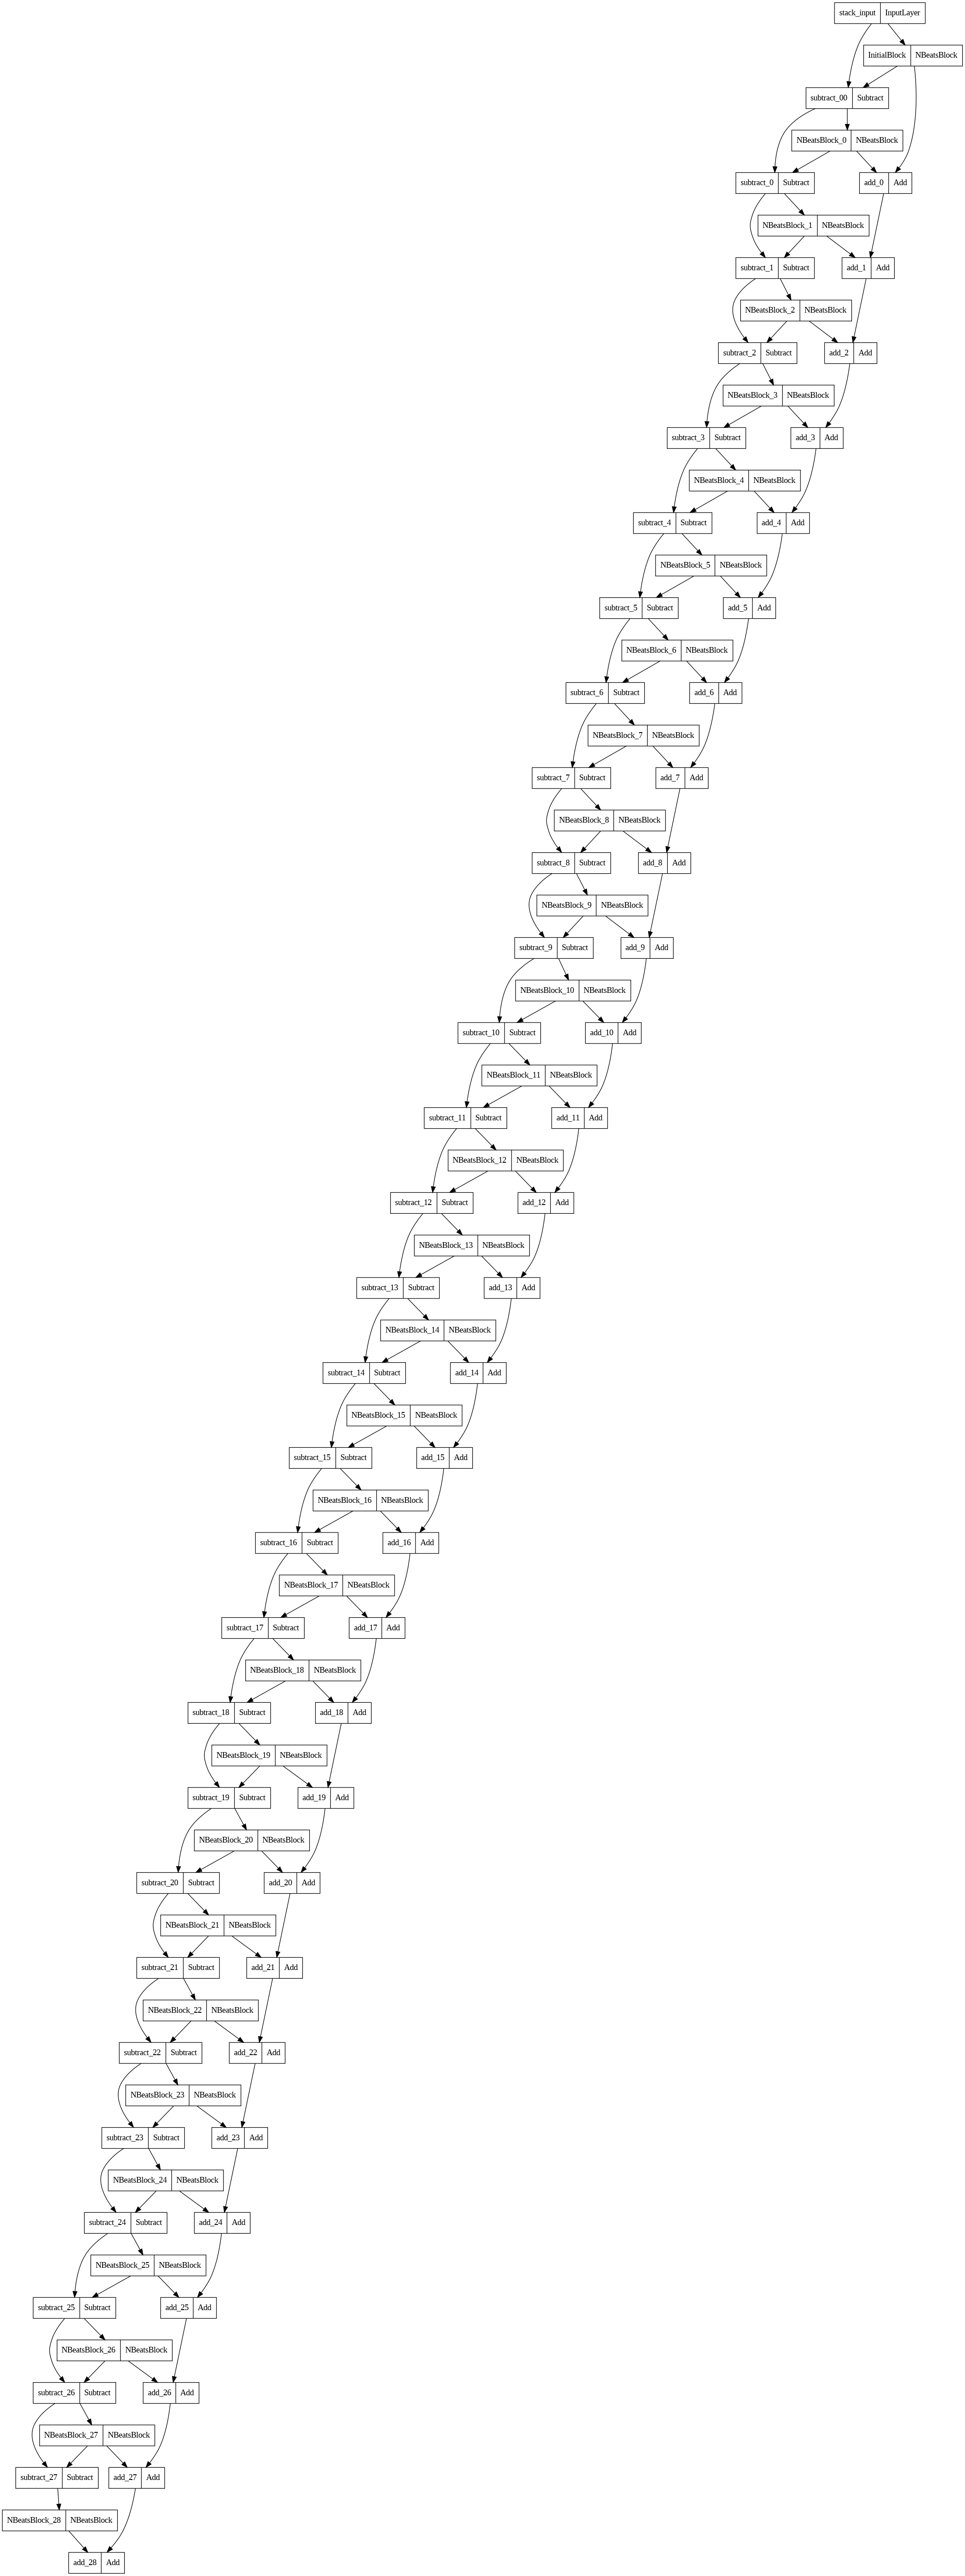

In [108]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

The N-BEATS model replicates the N-BEATS **generic architecture**, the training setups are largely the same, except for the N-BEATS paper used an ensemble of models to make predictions (multiple different loss functions and multiple different lookback windows), see Table 18 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) for more. An extension could be to setup this kind of training regime and see if it improves performance.

Save this version of the N-BEATS model.

### **Model 8: Creating an ensemble (stacking different models together)**
The next experiment is creating an [ensemble of models](https://en.wikipedia.org/wiki/Ensemble_learning).

An **ensemble** involves training and combining multiple different models on the same problem. Ensemble models are often the types of models you'll see winning data science competitions on websites like Kaggle.

For example, in the N-BEATS paper, they trained an ensemble of models (180 in total, see [section 3.4](https://arxiv.org/pdf/1905.10437.pdf)) to achieve the results they did using a combination of:

- Different loss functions (sMAPE, MASE and MAPE)
- Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)

The benefit of ensembling models is you get the "decision of the crowd effect". Rather than relying on a single model's predictions, [you can take the average or median of many different models](https://en.wikipedia.org/wiki/Ensemble_forecasting).

The keyword being: different.

It wouldn't make sense to train the same model 10 times on the same data and then average the predictions.

Fortunately, due to their random initialization, even deep learning models with the same architecture can produce different results.

What I mean by this is each time you create a deep learning model, it starts with random patterns (weights & biases) and then it adjusts these random patterns to better suit the dataset it's being trained on.

However, the process it adjusts these patterns is often a form of guided randomness as well (the SGD optimizer stands for stochastic or random gradient descent).

To create the ensemble models i'm going to be using a combination of:

- Different loss functions (MAE, MSE, MAPE)
- Randomly initialized models

Essentially, i'll be creating a suite of different models all attempting to model the same data.

And hopefully the combined predictive power of each model is better than a single model on its own.

I'll start by creating a function to produce a list of different models trained with different loss functions. Each layer in the ensemble models will be initialized with a random normal [(Gaussian) distribution](https://en.wikipedia.org/wiki/Normal_distribution) using [He normal initialization](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), this'll help estimating the prediction intervals later on.

**🔑 Note**: In your machine learning experiments, you may have already dealt with examples of ensemble models. Algorithms such as the [random forest model](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) are a form of ensemble, it uses a number of randomly created decision trees where each individual tree may perform poorly but when combined gives great results.



### **Constructing and fitting an ensemble of models (using different loss functions)**


In [109]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

Let's try it out by running `num_iter=5` runs for 1000 epochs. This will result in 15 total models (5 for each different loss function).

Of course, these numbers could be tweaked to create more models trained for longer.

**🔑 Note**: With ensembles, you'll generally find more total models means better performance. However, this comes with the tradeoff of having to train more models (longer training time) and make predictions with more models (longer prediction time).

In [110]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 193: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 518: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 618: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 500: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 610: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 710: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 144: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 478: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 578: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 121:

Write a function to use the list of trained ensemble models to make predictions and then return a list of predictions (one set of predictions per model)?

### **Making predictions with an ensemble model**

In [111]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [112]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 48ms/step


<tf.Tensor: shape=(15, 780), dtype=float32, numpy=
array([[39929.117, 39819.297, 40257.51 , ..., 69275.75 , 69887.484,
        69595.94 ],
       [39863.37 , 39443.156, 39975.824, ..., 69727.1  , 69470.516,
        69162.79 ],
       [39785.4  , 39806.75 , 40402.664, ..., 69470.28 , 69797.16 ,
        69777.05 ],
       ...,
       [39782.89 , 39831.06 , 40472.48 , ..., 69261.84 , 69844.53 ,
        69730.65 ],
       [39988.664, 39675.227, 40145.03 , ..., 69721.625, 69902.41 ,
        69447.56 ],
       [39865.246, 39663.684, 40193.133, ..., 69610.16 , 69790.266,
        69506.445]], dtype=float32)>

Now there are a set of ensemble predictions, they can be evaluated against the ground truth values.

However, since i've trained 15 models, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, let's take the median (you could also take the mean too but [the median is usually more robust than the mean](https://www.johndcook.com/blog/2009/03/06/student-t-distribution-mean-median/)).

In [113]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 627.02313,
 'mse': 998175.1,
 'rmse': 999.08716,
 'mape': 1.8772159,
 'mase': 1.0060378}

Looks like the ensemble model is the best performing model on the MAE metric so far.

In [114]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([39809.133, 39685.773, 40303.41 , 38254.516, 38969.293, 39514.527,
       38766.04 , 38359.996, 37970.188, 38682.12 ], dtype=float32)>

In [115]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([39798.5  , 39675.227, 40278.94 , 38228.965, 38975.965, 39554.918,
       38750.113, 38359.676, 37981.75 , 38674.914], dtype=float32)

In [116]:
# Evaluate ensemble model(s) predictions
ensemble_results_mean = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean) # take the mean across all ensemble predictions
ensemble_results_mean

{'mae': 628.0182,
 'mse': 997839.3,
 'rmse': 998.91907,
 'mape': 1.8809875,
 'mase': 1.0076343}

In [117]:
# Evaluate ensemble model(s) predictions
ensemble_results_median = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median) # take the median across all ensemble predictions
ensemble_results_median

{'mae': 627.02313,
 'mse': 998175.1,
 'rmse': 999.08716,
 'mape': 1.8772159,
 'mase': 1.0060378}

### **Plotting the prediction intervals (uncertainty estimates) of our ensemble**
Right now all of the model's (prior to the ensemble model) are predicting single points.

Meaning, given a set of `WINDOW_SIZE=7` values, the model will predict `HORIZION=1`.

But what might be more helpful than a single value?

Perhaps a range of values?

For example, if a model is predicting the price of Bitcoin to be 50,000 USD tomorrow, would it be helpful to know it's predicting the 50,000 USD because it's predicting the price to be between 48,000 and 52,000USD? (note: "$" has been omitted from the previous sentence due to formatting issues)

Knowing the range of values a model is predicting may help you make better decisions for your forecasts.

You'd know that although the model is predicting 50,000USD (a **point prediction**, or single value in time), the value could actually be within the range 48,000USD to 52,000USD (of course, the value could also be outside of this range as well).

These kind of prediction ranges are called **prediction intervals** or **uncertainty estimates**. And they're often as important as the forecast itself.

Why?

Because **point predictions** are almost always going to be wrong. So having a range of values can help with decision making.

**📖 Resource(s)**:

The steps we're about to take have been inspired by the Machine Learning Mastery blog post [Prediction Intervals for Deep Learning Neural Networks](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/). Check out the post for more options to measure uncertainty with neural networks.
For an example of uncertainty estimates being used in the wild, I'd also refer to Uber's [Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber](https://eng.uber.com/neural-networks-uncertainty-estimation/) blog post.

One way of getting the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by [1.96](https://en.wikipedia.org/wiki/1.96) (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [118]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

Now we've got the upper and lower bounds for the the 95% prediction interval, let's plot them against the ensemble model's predictions.

To do so, use the plotting function above as well as the [matplotlib.pyplot.fill_between()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html) method to shade in the space between the upper and lower bounds.

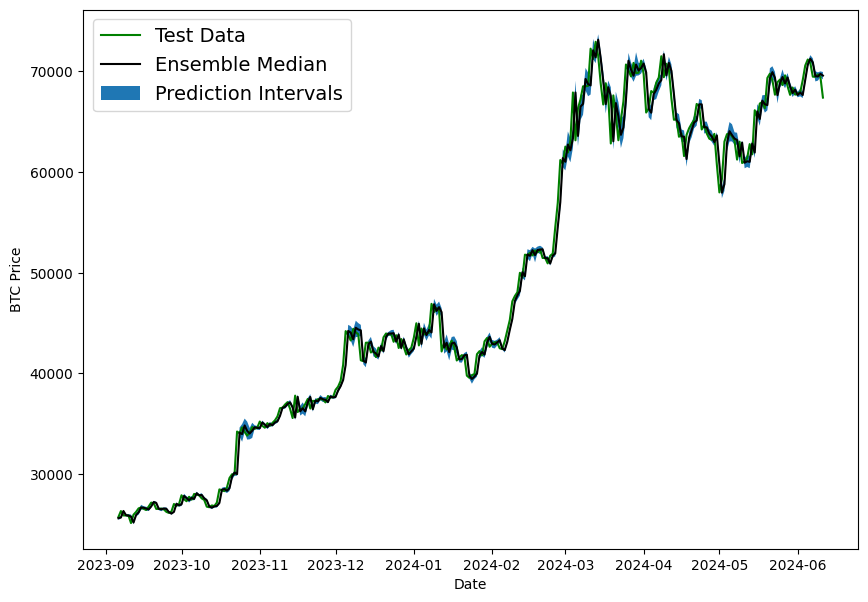

In [119]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

I've just plotted:

- The test data (the ground truth Bitcoin prices)
- The median of the ensemble predictions
- The 95% prediction intervals (assuming the data is Gaussian/normal, the model is saying that 95% of the time, predicted value should fall between this range)
What can you tell about the ensemble model from the plot above?

It looks like the ensemble predictions are lagging slightly behind the actual data.

And the prediction intervals are fairly low throughout.

The combination of lagging predictions as well as low prediction intervals indicates that the ensemble model may be **overfitting** the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.

This would explain why previous attempts to beat the naïve forecast have been futile.

We can test this hypothesis of overfitting by creating a model to make predictions into the future and seeing what they look like.

**🔑 Note**: The prediction intervals above assume that the data we're using comes from a Gaussian/normal distribution (also called a bell curve), however, open systems rarely follow the Gaussian. For further reading on this topic, I'd recommend reading [The Black Swan by Nassim Nicholas Taleb](https://en.wikipedia.org/wiki/The_Black_Swan:_The_Impact_of_the_Highly_Improbable), especially Part 2 and Chapter 15.

### **Aside: two types of uncertainty (coconut and subway)**
Inherently, we know we cannot predict the future.

That doesn't mean trying to isn't valuable.

For many things, future predictions are helpful. Such as knowing the bus you're trying to catch to the library leaves at 10:08am. The time 10:08am is a **point prediction**, if the bus left at a random time every day, how helpful would it be?

Just like saying the price of Bitcoin tomorrow will be 50,000USD is a point prediction.

However, as discussed, knowing a **prediction interval** or **uncertainty estimate** can be as helpful or even more helpful than a point prediction itself.

Uncertainty estimates seek out to qualitatively and quantitatively answer the questions:

- What can my model know? (with perfect data, what's possible to learn?)
- What doesn't my model know? (what can a model never predict?)
There are two types of uncertainty in machine learning you should be aware of:

- **Aleatoric uncertainty** - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.

  - Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at exactly 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
  - When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).
- **Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.

  - The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach.
    - If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing?
    - But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
  - Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.

The lines between these are blurred (one type of uncertainty can change forms into the other) and they can be confusing at first but are important to keep in mind for any kind of time series prediction.

If you ignore the uncertanties, are you really going to get a reliable prediction?

Perhaps another example might help.

### **Uncertainty in dating**
Let's say you're going on a First Date Feedback Radio Show to help improve your dating skills.

Where you go on a blind first date with a girl and the radio hosts record the date and then playback snippets of where you could've improved.

And now let's add a twist.

Last week your friend went on the same show. They told you about the girl they met and how the conversation went.

Because you're now a machine learning engineer, you decide to build a machine learning model to help you with first date conversations.

What levels of uncertainty do we have here?

From an **aleatory uncertainty** (data) point of view, no matter how many conversations of first dates you collect, the conversation you end up having will likely be different to the rest (the best conversations have no subject and appear random).

From an **epistemic uncertainty** (model) point of view, if the date is truly blind and both parties don't know who they're seeing until they meet in person, the epistemic uncertainty would be high. Because now you have no idea who the person you're going to meet is nor what you might talk about.

However, the level of epistemic uncertainty would be reduced if your friend told about the girl they went on a date with last week on the show and it turns out you're going on a date with the same girl.

But even though you know a little bit about the girl, your **aleatory uncertainty** (or subway uncertainty) is still high because you're not sure where the conversation will go.

### **Learning more on uncertainty**
The field of quantifying uncertainty estimation in machine learning is a growing area of research.

If you'd like to learn more I'd recommend the following.

**📖 Resources**: Places to learn more about uncertainty in machine learning/forecasting:

- 🎥 [MIT 6.S191: Evidential Deep Learning and Uncertainty](https://youtu.be/toTcf7tZK8c)
- [Uncertainty quantification on Wikipedia](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty)
- [Why you should care about the Nate Silver vs. Nassim Taleb Twitter war](https://towardsdatascience.com/why-you-should-care-about-the-nate-silver-vs-nassim-taleb-twitter-war-a581dce1f5fc) by Isaac Faber - a great insight into the role of uncertainty in the example of election prediction.
- [3 facts about time series forecasting that surprise experienced machine learning practitioners](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) by Skander Hannachi - fantastic outline of some of the main mistakes people make when building forecasting models, especially forgetting about uncertainty estimates.
- [Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber](https://eng.uber.com/neural-networks-uncertainty-estimation/) - a discussion on techniques Uber used to engineer uncertainty estimates into their time series neural networks.


### **Model 9: Train a model on the full historical data to make predictions into future**
What would a forecasting model be worth if we didn't use it to predict into the future?

It's time we created a model which is able to make future predictions on the price of Bitcoin.

To make predictions into the future, we'll train a model on the full dataset and then get to make predictions to some future horizon.

Why use the full dataset?

Previously, we split the data into training and test sets to evaluate how well the model did on pseudo-future data (the test set).

But since the goal of a forecasting model is to predict values into the actual-future, we won't be using a test set.

**🔑 Note**: Forecasting models need to be retrained every time a forecast is made. Why? Because if Bitcoin prices are updated daily and you predict the price for tomorrow. Your model is only really valid for one day. When a new price comes out (e.g. the next day), you'll have to retrain the model to incorporate that new price to predict the next forecast.

In [120]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.6550,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.4550,12.5,123.6550,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.5848,12.5,125.4550,123.6550,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.6747,12.5,108.5848,125.4550,123.655,NaN,NaN,NaN,NaN
2013-10-05,121.3387,12.5,118.6747,108.5848,125.455,123.655,NaN,NaN,NaN


In [121]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [122]:
X_all[:5], y_all[:5]

(array([[121.795 , 120.6553, 121.3387, 118.6747, 108.5848, 125.455 ,
         123.655 ],
        [123.033 , 121.795 , 120.6553, 121.3387, 118.6747, 108.5848,
         125.455 ],
        [124.049 , 123.033 , 121.795 , 120.6553, 121.3387, 118.6747,
         108.5848],
        [125.9612, 124.049 , 123.033 , 121.795 , 120.6553, 121.3387,
         118.6747],
        [125.2797, 125.9612, 124.049 , 123.033 , 121.795 , 120.6553,
         121.3387]]),
 array([123.033 , 124.049 , 125.9612, 125.2797, 125.9275]))

Windows and labels ready! Let's turn them into performance optimized TensorFlow Datasets by:

- Turning `X_all` and `y_all` into tensor Datasets using [tf.data.Dataset.from_tensor_slices()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
- Combining the features and labels into a Dataset tuple using [tf.data.Dataset.zip()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
- Batch and prefetch the data using [tf.data.Dataset.batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [tf.data.Dataset.prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) respectively

In [123]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

Create a model similar to `model_1` except with an extra layer, i'll also fit it to the entire dataset for 100 epochs.

In [124]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

### **Make predictions on the future**
So far, the various machine learning models have performed quite poorly at predicting the price of Bitcoin (time series forecasting in open systems is typically a game of luck), often worse than the naive forecast.

That doesn't mean i can't use the models to try and predict into the future.

To do so, i'll start by defining a variable `INTO_FUTURE` which decides how many timesteps i'd like to predict into the future.

In [125]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

Create a function which returns `INTO_FUTURE` forecasted values using a trained model.

To do so, i'll build the following steps:

1. Function which takes as input:
  - a list of values (the Bitcoin historical data)
  - a trained model (such as `model_9`)
  - a window into the future to predict (the `INTO_FUTURE` variable)
  - the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction
- Eventually future predictions will be made using the model's own previous predictions as input

In [126]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [127]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts
# i'm making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 91ms/step
Predicting on: 
 [71158.5455 70830.2702 69458.6146 69447.7584 69683.6751 69441.3017
 67379.9128] -> Prediction: 70498.0

1/1 [==============================] - 0s 32ms/step
Predicting on: 
 [70830.2702 69458.6146 69447.7584 69683.6751 69441.3017 67379.9128
 70498.    ] -> Prediction: 69682.53125

1/1 [==============================] - 0s 36ms/step
Predicting on: 
 [69458.6146  69447.7584  69683.6751  69441.3017  67379.9128  70498.
 69682.53125] -> Prediction: 68927.984375

1/1 [==============================] - 0s 51ms/step
Predicting on: 
 [69447.7584   69683.6751   69441.3017   67379.9128   70498.
 69682.53125  68927.984375] -> Prediction: 68894.1484375

1/1 [==============================] - 0s 52ms/step
Predicting on: 
 [69683.6751    69441.3017    67379.9128    70498.        69682.53125
 68927.984375  68894.1484375] -> Prediction: 69129.9296875

1/1 [==============================] - 0s 36ms/step
Predicting on: 
 [69441.3017    6

In [128]:
future_forecast[:10]

[70498.0,
 69682.53,
 68927.984,
 68894.15,
 69129.93,
 68428.24,
 68320.734,
 69596.305,
 68830.305,
 68408.414]

### **Plot future forecasts**
Right now, the forecasts has been made, they're just numbers on a page.

Plot the model's future forecasts against the historical data of Bitcoin, i'm going to need a series of future dates (future dates from the final date of where the dataset ends).

I'm going to create a function to return a date range from some specified start date to a specified number of days into the future (`INTO_FUTURE`).

To do so, i'll use a combination of NumPy's [datetime64 datatype](https://numpy.org/doc/stable/reference/arrays.datetime.html) (the Bitcoin dates are already in this datatype) as well as NumPy's timedelta64 method which helps to create date ranges.

In [129]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

The start date of the forecasted dates will be the last date of the dataset.

In [130]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2024-06-11 00:00:00')

In [131]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2024-06-12', '2024-06-13', '2024-06-14', '2024-06-15',
       '2024-06-16', '2024-06-17', '2024-06-18', '2024-06-19',
       '2024-06-20', '2024-06-21', '2024-06-22', '2024-06-23',
       '2024-06-24', '2024-06-25'], dtype='datetime64[D]')

I've now got a list of dates i can use to visualize future Bitcoin predictions.

But to make sure the lines of the plot connect (try not running the cell below and then plotting the data to see what I mean), insert the last timestep and Bitcoin price of the training data to the `next_time_steps` and `future_forecast` arrays.

In [132]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])
next_time_steps, future_forecast

(array(['2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14',
        '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18',
        '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22',
        '2024-06-23', '2024-06-24', '2024-06-25'], dtype='datetime64[D]'),
 array([67379.914, 70498.   , 69682.53 , 68927.984, 68894.15 , 69129.93 ,
        68428.24 , 68320.734, 69596.305, 68830.305, 68408.414, 68482.445,
        68486.445, 68092.7  , 68388.664], dtype=float32))

In [133]:
len(next_time_steps), len(future_forecast)

(15, 15)

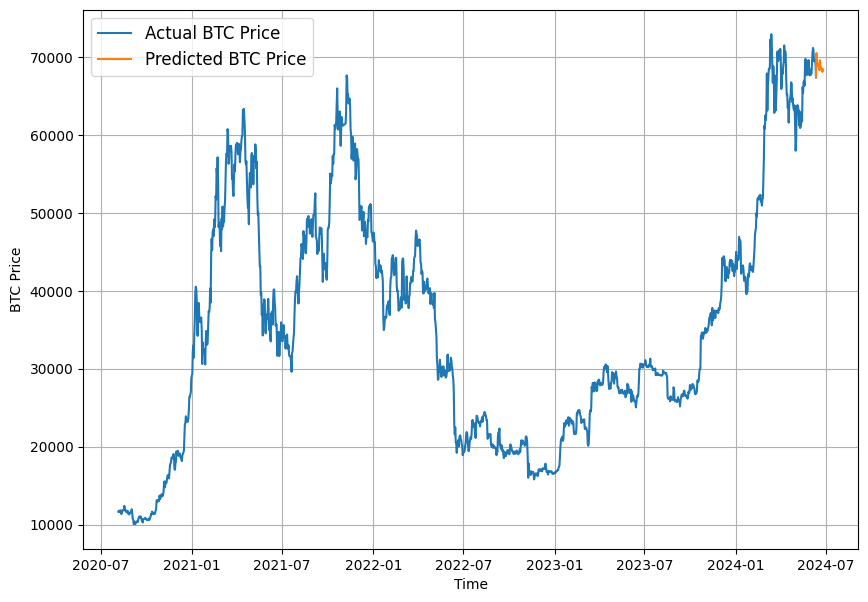

In [134]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, prices, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

It looks like the predictions are starting to form a bit of a cyclic pattern (up and down in the same way).

Perhaps that's due to the model overfitting the training data and not generalizing well for future data. Also, the further you predict into the future, the higher the chance for error (try seeing what happens when you predict 100 days into the future).

But of course, we can't measure these predictions as they are because after all, they're predictions into the actual-future (by the time you read this, the future might have already happened, if so, how did the model go?).


**🔑 Note**: A reminder, the predictions i've made here are not financial advice. And by now, you should be well aware of just how poor machine learning models can be at forecasting values in an open system - anyone promising you a model which can "beat the market" is likely trying to scam you, oblivious to their errors or very lucky.

### **Model 10: Why forecasting is BS (the turkey problem 🦃)**
When creating any kind of forecast, you must keep the **turkey problem** in mind.

The **turkey problem** is an analogy for when your observational data (your historical data) fails to capture a future event which is catostrophic and could lead you to ruin.

The story goes, a turkey lives a good life for 1000 days, being fed every day and taken care of by its owners until the evening before Thanksgiving.

Based on the turkey's observational data, it has no reason to believe things shouldn't keep going the way they are.

In other words, how could a turkey possibly predict that on day 1001, after 1000 consectutive good days, it was about to have a far from ideal day.

How does this relate to predicting the price of Bitcoin (or the price of any stock or figure in an open market)?

You could have the historical data of Bitcoin for its entire existence and build a model which predicts it perfectly.

But then one day for some unknown and unpredictable reason, the price of Bitcoin plummets 100x in a single day.

Of course, this kind of scenario is unlikely.

But that doesn't take away from its significance.

Think about it in your own life, how many times have the most significant events happened seemingly out of the blue?

As in, you could go to a cafe and run into the love of your life, despite visiting the same cafe for 10-years straight and never running into this person before.

The same thing goes for predicting the price of Bitcoin, you could make money for 10-years straight and then lose it all in a single day.

It doesn't matter how many times you get paid, it matters the amount you get paid.

**📖 Resource**: If you'd like to learn more about the turkey problem, I'd recommend the following:

- [Explaining both the XIV trade and why forecasting is BS](https://youtu.be/hRwimmE2wEk) by Nassim Taleb
- [The Black Swan](https://en.wikipedia.org/wiki/The_Black_Swan:_The_Impact_of_the_Highly_Improbable) by Nassim Taleb (epsecially Chapter 4 which outlines and discusses the turkey problem)

Let's get specific and see how the turkey problem affects us modelling the historical and future price of Bitcoin.

To do so, we're going to manufacture a highly unlikely data point into the historical price of Bitcoin, the price falling 100x in one day.

**🔑 Note:** A very unlikely and unpredictable event such as the price of Bitcoin falling 100x in a single day (note: the adjective "unlikely" is based on the historical price changes of Bitcoin) is also referred to a [Black Swan event](https://en.wikipedia.org/wiki/Black_swan_theory). A Black Swan event is an unknown unknown, you have no way of predicting whether or not it will happen but these kind of events often have a large impact.

In [136]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [137]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

array([67891.8579  , 69109.3176  , 70565.2068  , 71158.5455  ,
       70830.2702  , 69458.6146  , 69447.7584  , 69683.6751  ,
       69441.3017  ,   673.799128])

Notice the last value is 100x lower than what it actually was (remember, this is not a real data point, its only to illustrate the effects of the turkey problem).

Now we've got Bitcoin prices including a turkey problem data point, let's get the timesteps.

In [138]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2024-06-02T00:00:00.000000000', '2024-06-03T00:00:00.000000000',
       '2024-06-04T00:00:00.000000000', '2024-06-05T00:00:00.000000000',
       '2024-06-06T00:00:00.000000000', '2024-06-07T00:00:00.000000000',
       '2024-06-08T00:00:00.000000000', '2024-06-09T00:00:00.000000000',
       '2024-06-10T00:00:00.000000000', '2024-06-11T00:00:00.000000000'],
      dtype='datetime64[ns]')

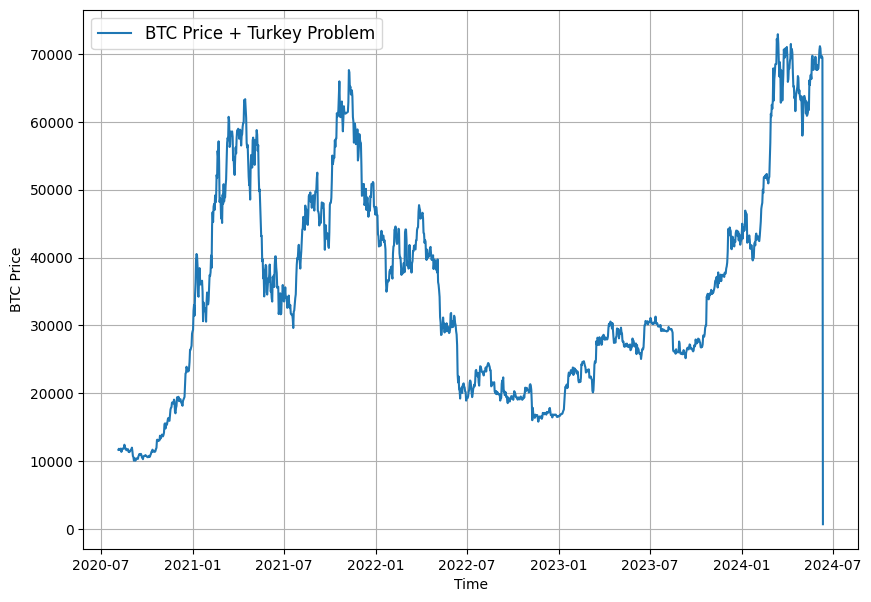

In [139]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

How do you think building a model on this data will go?

Remember, all i've changed is a single data point out of the entire dataset.

Before building a model, create some windowed datasets with the turkey data.

In [140]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(3116, 780, 3116, 780)

### **Building a turkey model (model to predict on turkey data)**
With the updated data, i only changed 1 value.

Let's see how it affects a model.

To keep things comparable to previous models, I'll create a `turkey_model` which is a clone of `model_1` (same architecture, but different data).

That way, when i evaluate the `turkey_model` i can compare its results to `model_1_results` and see how much a single data point can influence a model's performance.

In [141]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [142]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

25/25 [==============================] - 0s 3ms/step - loss: 721.3154


721.3153686523438

In [143]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

25/25 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([39712.684, 39468.777, 40154.746, 38333.457, 38921.836, 39431.098,
       38481.883, 38401.164, 38010.387, 38402.277], dtype=float32)>

In [144]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 15975.951,
 'mse': 473328420.0,
 'rmse': 20633.127,
 'mape': 57.216156,
 'mase': 22.536558}

And with just one value change, the error metrics goes through the roof.

Check out how `model_1` went on unmodified Bitcoin data (no turkey problem).

In [145]:
model_1_results

{'mae': 618.91345,
 'mse': 990477.4,
 'rmse': 995.2273,
 'mape': 1.8545363,
 'mase': 0.9930261}

By changing just one value, the `turkey_model` MAE increases almost 26x over `model_1`.

Finally, visualize the turkey predictions over the test turkey data.

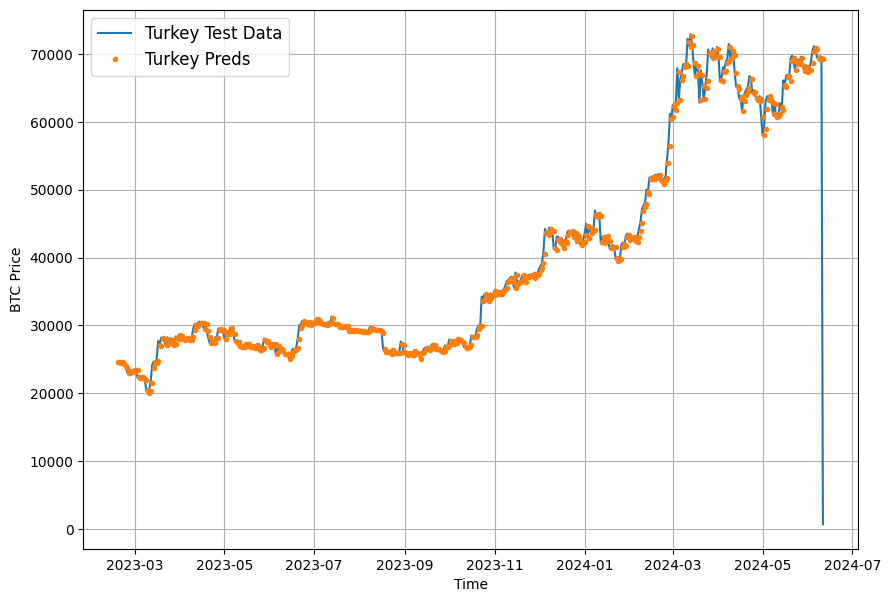

In [146]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

Why does this happen?

Why does the model fail to capture the turkey problem data point?

Think about it like this, just like a turkey who lives 1000 joyful days, based on observation alone has no reason to believe day 1001 won't be as joyful as the last, a model which has been trained on historical data of Bitcoin which has no single event where the price decreased by 100x in a day, has no reason to predict it will in the future.

A model cannot predict anything in the future outside of the distribution it was trained on.

In turn, highly unlikely price movements (based on historical movements), upward or downward will likely never be part of a forecast.

However, as we've seen, despite their unlikeliness, these events can have huge impacts to the performance of our models.

**📖 Resource**: For a great article which discusses Black Swan events and how they often get ignored due to the assumption that historical events come from a certain distribution and that future events will come from the same distribution see [Black Swans, Normal Distributions and Supply Chain Risk](https://spendmatters.com/uk/black-swans-normal-distributions-supply-chain-risk/) by Spend Matters.

### **Compare Models**
I've trained a bunch of models.

And if anything, I've seen just how poorly machine learning and deep learning models are at forecasting the price of Bitcoin (or any kind of open market value).

To highlight this, compare the results of all of the modelling experiments i've performed so far.

In [147]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,622.818176,9.967368e+05,998.367065,1.857831,0.999291
model_1_dense_w7_h1,618.913452,9.904774e+05,995.227295,1.854536,0.993026
model_2_dense_w30_h1,653.639648,1.066077e+06,1032.510132,1.982225,1.053377
model_3_dense_w30_h7,691.715149,1.131973e+06,734.932434,2.100981,1.114738
model_4_CONV1D,624.877014,1.003774e+06,1001.885132,1.879967,1.002594
model_5_LSTM,636.538635,1.027358e+06,1013.586914,1.917466,1.021305
model_6_multivariate,618.545288,9.855806e+05,992.764160,1.855435,0.992435
model_8_NBEATs,635.725464,1.032492e+06,1016.116272,1.912786,1.020000
model_9_ensemble,627.023132,9.981751e+05,999.087158,1.877216,1.006038
model_10_turkey,15975.951172,4.733284e+08,20633.126953,57.216156,22.536558


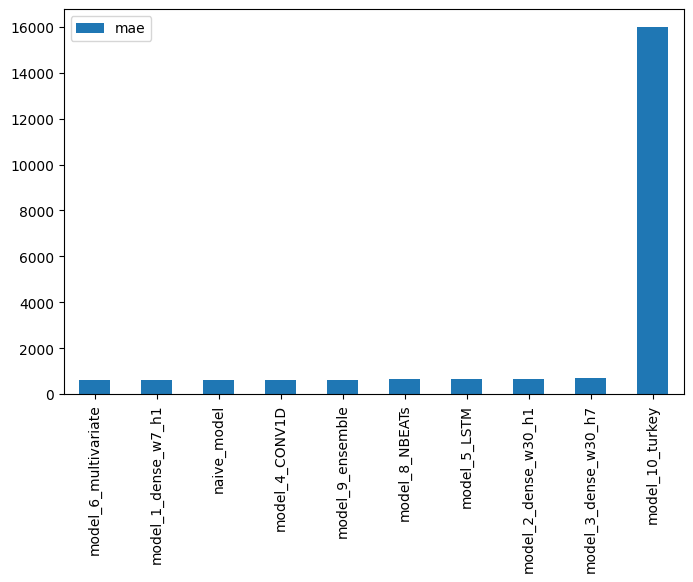

In [149]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(8, 5), kind="bar");

The model_6_multivariate model performed better than the other models. The majority of the deep learning models perform on par or only slightly better than the naive model. And for the turkey model, changing a single data point destroys its performance.

**🔑 Note:** Just because one type of model performs better here doesn't mean it'll perform the best elsewhere (and vice versa, just because one model performs poorly here, doesn't mean it'll perform poorly elsewhere).

As I said at the start, this is not financial advice.